## Loading the MNIST dataset

In [1]:
import tensorflow
from tensorflow.keras.datasets.mnist import load_data
(trainX,trainY),(testX,testY)=load_data()
print("Train:",trainX.shape,trainY.shape)
print("Test:",testX.shape,testY.shape)
from tensorflow.

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


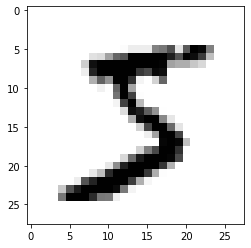

In [2]:
import matplotlib.pyplot as plt
plt.imshow(trainX[0],cmap="gray_r")

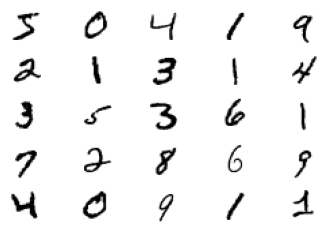

In [3]:
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis("off")
    plt.imshow(trainX[i],cmap="gray_r")
plt.show()

## Discriminator

In [4]:
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [5]:
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X


In [6]:
from numpy.random import randint
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [7]:
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [8]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>100 real=98% fake=100%


# Generator

In [9]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model

def define_generator(latent_dim = 50):
    model = Sequential()
    #Foundation for 7*7 image
    nNodes = 128*7*7
    model.add(Dense(nNodes,input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    #Upsampling to 14*14
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #Upsampling to 28*28
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,(7,7),activation="sigmoid",padding="same"))
    return model

model = define_generator()
model.summary()
#plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              319872    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [11]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

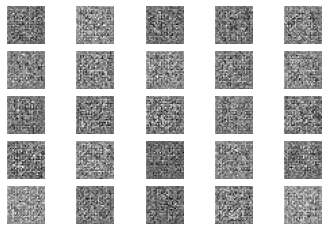

In [12]:
from numpy.random import randn
from matplotlib import pyplot
latent_dim=100
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    pyplot.subplot(5, 5, 1 + i)
    # turn off axis labels
    pyplot.axis('off')
    # plot single image
    pyplot.imshow(X[i], cmap='gray_r')
# show the figure
pyplot.show()

In [13]:
def define_gan(g_model,d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002,beta_1=0.2)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    return model

In [14]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
#plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 37825     
Total params: 1,202,114
Trainable params: 1,164,289
Non-trainable params: 37,825
_________________________________________________________________


In [15]:
def save_plot(examples,epoch, n=10):
    for i in range(n*n):
        pyplot.subplot(n,n,i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i],cmap="gray_r")
    filename = "generated_plot_"+str(epoch)+".png"
    pyplot.savefig(filename)
    pyplot.close()

In [16]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [19]:
from numpy import vstack
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [20]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.703, g=0.673
>1, 2/234, d=0.689, g=0.680
>1, 3/234, d=0.688, g=0.700
>1, 4/234, d=0.685, g=0.702
>1, 5/234, d=0.677, g=0.704
>1, 6/234, d=0.672, g=0.717
>1, 7/234, d=0.670, g=0.720
>1, 8/234, d=0.657, g=0.723
>1, 9/234, d=0.658, g=0.727
>1, 10/234, d=0.661, g=0.730
>1, 11/234, d=0.652, g=0.729
>1, 12/234, d=0.649, g=0.728
>1, 13/234, d=0.643, g=0.723
>1, 14/234, d=0.642, g=0.721
>1, 15/234, d=0.640, g=0.721
>1, 16/234, d=0.632, g=0.708
>1, 17/234, d=0.632, g=0.700
>1, 18/234, d=0.632, g=0.695
>1, 19/234, d=0.624, g=0.689
>1, 20/234, d=0.629, g=0.675
>1, 21/234, d=0.626, g=0.666
>1, 22/234, d=0.628, g=0.659
>1, 23/234, d=0.625, g=0.652
>1, 24/234, d=0.627, g=0.650
>1, 25/234, d=0.638, g=0.636
>1, 26/234, d=0.645, g=0.635
>1, 27/234, d=0.640, g=0.658
>1, 28/234, d=0.637, g=0.683
>1, 29/234, d=0.629, g=0.712
>1, 30/234, d=0.617, g=0.735
>1, 31/234, d=0.615, g=0.727
>1, 32/234, d=0.619, g=0.711
>1, 33/234, d=0.631, g=0.689
>1, 34/234, d=0.622, g=0.680
>1, 35/234, d=0.617, g=

KeyboardInterrupt: 